# Set up the environment

Before running the notebook, please install the necessary packages and environment by running the following shell commands in your terminal:

```bash
# Create the conda environment from the provided environment file
conda env create -f ../conda_env_pkgs.yml -n soc_model_env

# Activate the new environment
conda activate soc_model_env

# Launch Jupyter Notebook from within the environment
jupyter notebook


In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, root_mean_squared_error

# Authenticate and Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project= "ee-christopherharrellgis")

#Initialize Map
Map = geemap.Map()

### Data Imports

In [287]:
# SOC samples table loaded from earth engine asset
soc_sample_points = ee.FeatureCollection("users/christopherharrellgis/soc_samples")

# Buffer sample points by 10km and return bounds
study_area = soc_sample_points.geometry().bounds().buffer(10000).bounds()

# Harmonized Sentinel-2 SR and Cloud Score
s2_sr = ee.ImageCollection('COPERNICUS/S2_SR')
s2CloudScore = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

# Climate Data
tc_climate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')

# DEM
dem = ee.ImageCollection('COPERNICUS/DEM/GLO30')

# Landcover
lc = ee.ImageCollection("ESA/WorldCover/v200").first()


#### Define Global Variables

In [347]:
# Global variables
output_data_folder = "../soc/data/"

# Start/End Dates
start_date = "2018-01-01"
end_date = "2023-01-01"

# Sentinel-2
QA_Band = "cs_cdf"
CLEAR_THRESHOLD = 0.60
S2_SCALE_FACTOR = 0.0001

# Terra Climate
TC_TEMP_SCALE_FACTOR = 0.1

#### General Utility Functions

In [261]:
def temporal_filter(imageCollection, start_date, end_date):
    """Filters an ImageCollection by start and end dates"""
    return imageCollection.filterDate(start_date, end_date)

def spatial_filter(imageCollection, region):
    """Filters an ImageCollection by region"""
    return imageCollection.filterBounds(region)

def temporal_reducer(col):
    """Reduces an ImageCollection over time by computing the mean, 10th and 90th percentiles, and standard deviation for each pixel."""
    reducer = ee.Reducer.mean() \
    .combine(ee.Reducer.percentile([10, 90]), sharedInputs = True) \
    .combine(ee.Reducer.stdDev(), sharedInputs = True)
    return col.reduce(reducer) 


def print_dataset_info(data):
    """Prints basic information (name, type, projection, scale) about an ee.Image or ee.ImageCollection."""
    if isinstance(data, ee.ImageCollection):
        first_image = ee.Image(data.first())
        name = data.get('system:id').getInfo() or 'ImageCollection'
    elif isinstance(data, ee.Image):
        first_image = data
        name = data.get('system:id').getInfo() or 'Image'
    else:
        raise TypeError("Input must be an ee.Image or ee.ImageCollection")

    # Get projection and scale
    band = first_image.bandNames().get(0)
    proj = first_image.select([band]).projection()
    crs = proj.crs().getInfo()
    scale = proj.nominalScale().getInfo()

    # Print information
    print(f"Dataset Name: {name}")
    print(f"Type: {'ImageCollection' if isinstance(data, ee.ImageCollection) else 'Image'}")
    print(f"CRS: {crs}")
    print(f"Scale: {scale} meters")


#### DEM processing

In [256]:
def calc_elevation(image):
    """Extracts and mosaics the 'DEM' band from an image collection and sets its projection as 'ELEVATION'."""
    projection = image.first().projection()
    dem = (
        image.select('DEM')
        .mosaic()
        .rename('ELEVATION')
        .setDefaultProjection(projection)
    )
    return dem

def calc_slope(dem):
    """Calculates the slope in degrees from a digital elevation model (DEM)."""
    slope = ee.Terrain.slope(dem).rename('SLOPE')
    return slope

def calc_aspect(dem):
    """Calculates the aspect from a digital elevation model (DEM)."""
    aspect = ee.Terrain.aspect(dem).rename('ASPECT')
    return aspect

def calc_terrain(dem):
    """Computes terrain attributes by generating elevation, slope, and aspect bands from a DEM."""
    elev = calc_elevation(dem)
    return elev.addBands(calc_slope(elev)).addBands(calc_aspect(elev))

#### Sentinel-2 processing

In [263]:
def s2_cloud_mask(image):
    """Applies a cloud mask based on the QA band using a threshold to identify clear pixels."""
    return image.select(QA_Band).gte(CLEAR_THRESHOLD)

def calc_ndvi(image):
    """Calculates the Normalized Difference Vegetation Index (NDVI) from NIR and Red bands."""
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI')

def calc_evi(image):
    """Calculates the Enhanced Vegetation Index (EVI) from an image and returns it as a single-band image named 'EVI'."""
    return image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ).rename('EVI')


def calc_ndwi(image):
    """Calculates the Normalized Difference Water Index (NDWI) from Green and NIR bands."""
    return image.normalizedDifference(['B3', 'B8']).rename('NDWI')

def calc_mndwi(image):
    """Calculates the Modified Normalized Difference Water Index (MNDWI) from SWIR1 and NIR bands."""
    return image.normalizedDifference(['B11', 'B8']).rename('MNDWI')

def calc_savi(image):
    """Calculates the Soil-Adjusted Vegetation Index (SAVI) from an image and returns it as a single-band image named 'SAVI'."""
    return image.expression(
        '((B8 - B4) / (B8 + B4 + 0.5)) * 1.5',
        {
            'B8': image.select('B8'),
            'B4': image.select('B4'),
        }
    ).rename('SAVI')

def calc_veg_indices(image):
    """Adds multiple vegetation and water indices (NDVI, EVI, NDWI, MNDWI, SAVI) as bands to the image."""
    return image.addBands(
        [calc_ndvi(image), calc_evi(image), calc_ndwi(image), calc_mndwi(image), calc_savi(image)]
    )

def process_s2_image(image):
    """Applies cloud masking, scales spectral bands, computes vegetation indices, and retains metadata."""
    mask = s2_cloud_mask(image)
    image = image.select(
        ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]
    ).multiply(S2_SCALE_FACTOR)
    indices = calc_veg_indices(image).updateMask(mask)
    return indices.copyProperties(image, ["system:time_start"])

def link_s2_collections(col1, col2):
    """Links a secondary collection (e.g., QA) to a primary Sentinel-2 collection by matching and attaching specified bands."""
    linked_collection = col1.linkCollection(col2, [QA_Band])
    return linked_collection


#### TerraClimate Processing

In [268]:
def annual_stats(date):
    """Calculates annual total precipitation, evapotranspiration, runoff, deficit, and soil moisture from TerraClimate data for a given year."""
    start = ee.Date.fromYMD(date, 1, 1)
    end = start.advance(1, "year")
    image = tc_climate.filterDate(start, end).reduce(ee.Reducer.sum())
    total_precip = image.select('pr_sum').rename('TOTAL_PRECIP')
    total_aet = image.select('aet_sum').rename('TOTAL_AET')
    total_runoff = image.select('ro_sum').rename('TOTAL_RUNOFF')
    total_def = image.select('def_sum').rename('TOTAL_DEF')
    total_soil_m = image.select('soil_sum').rename('TOTAL_SOIL_M')
    return total_precip.addBands(total_aet).addBands(total_runoff).addBands(total_def).addBands(total_soil_m)

def intra_annual_stats(start, end):
    """Generates a multi-year ImageCollection of annual TerraClimate water balance totals by applying `annual_stats` from start to end year."""
    date1 = ee.Date(start).get('year')
    date2 = ee.Date(end).get('year')
    return ee.ImageCollection(ee.List.sequence(date1, date2).map(annual_stats))

#### WorldCover 2021 Processing

In [289]:
def encode_landcover(image):
    """Remaps ESA WorldCover class values to 0-10 and returns a binary image with one byte band per class indicating pixel membership."""
    class_values = list(range(10, 100, 10)) + [95, 100]
    remap_values = ee.List.sequence(0, 10)
    remapped_image = image.remap(class_values, remap_values).toByte()
    binary_bands = [remapped_image.eq(i).rename(f'LC_{i}') for i in range(len(class_values))]
    binary_image = ee.Image(binary_bands).rename([f'LC_{i}' for i in range(len(class_values))])
    return binary_image

#### Processing Remote Sensing Data

In [288]:
# Sentinel-2 SR
s2 = temporal_filter(s2_sr, start_date, end_date)
s2 = spatial_filter(s2, study_area)
s2_linked = link_s2_collections(s2, s2CloudScore)
s2_processed = s2_linked.map(process_s2_image)
s2_vars = temporal_reducer(s2_processed)

# DEM
terrain = calc_terrain(dem)
terrain

# TerraClimate
annual_collection = intra_annual_stats(start_date, end_date)
annual_climate_stats = temporal_reducer(annual_collection)
monthly_climate_stats = temporal_reducer(tc_climate)
climate_stats = annual_climate_stats.addBands(monthly_climate_stats)

# WorldCover
lc = encode_landcover(lc)

#### Combine covariates into a single multi-band Image

In [293]:
combined_covariates = s2_vars.addBands(terrain).addBands(climate_stats).addBands(lc)

In [ ]:
def extract_pixel_values(points, image):
    """Extract pixel values for each point from each band of a multiband Image"""
    training_fc = image.sampleRegions(
        collection=points,
        scale=10,
        tileScale=16,
        geometries=True
    )
    return training_fc

training_features = extract_pixel_values(soc_sample_points, combined_covariates)

# Export FeatureCollection to earth engine asset
task = ee.batch.Export.table.toAsset(
    collection=training_features,
    description="soc_training_features",
    assetId="users/christopherharrellgis/soc_training_features"
)

task.start()

##### Calculate Pearson correlation of all covariates with the target

First compute the Pearson correlation coefficient between each covariate and the target variable (MgC_per_ha), ranking the covariates by the strength of their correlation. Then, iteratively select the top 5 covariates that are most strongly correlated with the target while ensuring that no two selected_predictors covariates are highly correlated with each other (i.e., absolute Pearson’s r < 0.8)

In [342]:
# SOC training features loaded from earth engine asset
soc_training_fc = ee.FeatureCollection("users/christopherharrellgis/soc_training_features")

features = soc_training_fc.getInfo()['features']
data = [f['properties'] for f in features]
soc_training_df = pd.DataFrame(data)

soc_training_df = soc_training_df.drop(columns=['plot_no', 'MgC_SE'])

target_variable = 'MgC_per_ha'
covariates = [col for col in soc_training_df.columns if col != target_variable]

# Compute Pearson's r for each covariate
correlations = {
    cov: pearsonr(soc_training_df[cov], soc_training_df[target_variable])[0]
    for cov in covariates
}

# Convert to DataFrame and sort by absolute correlation
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['pearson_r'])
correlation_df['abs_r'] = correlation_df['pearson_r'].abs()
correlation_df = correlation_df.sort_values('abs_r', ascending=False)

selected_predictors = []
threshold = 0.8  # correlation threshold to detect multicollinearity

for candidate in correlation_df.index:
    if len(selected_predictors) == 5:
        break
    is_correlated = False
    for s in selected_predictors:
        r = abs(pearsonr(soc_training_df[candidate], soc_training_df[s])[0])
        if r >= threshold:
            is_correlated = True
            break
    if not is_correlated:
        selected_predictors.append(candidate)

print("selected_predictors covariates:")
print(selected_predictors)

selected_predictors covariates:
['B5_p90', 'B8_p10', 'B5_stdDev', 'TOTAL_RUNOFF_stdDev', 'B12_stdDev']


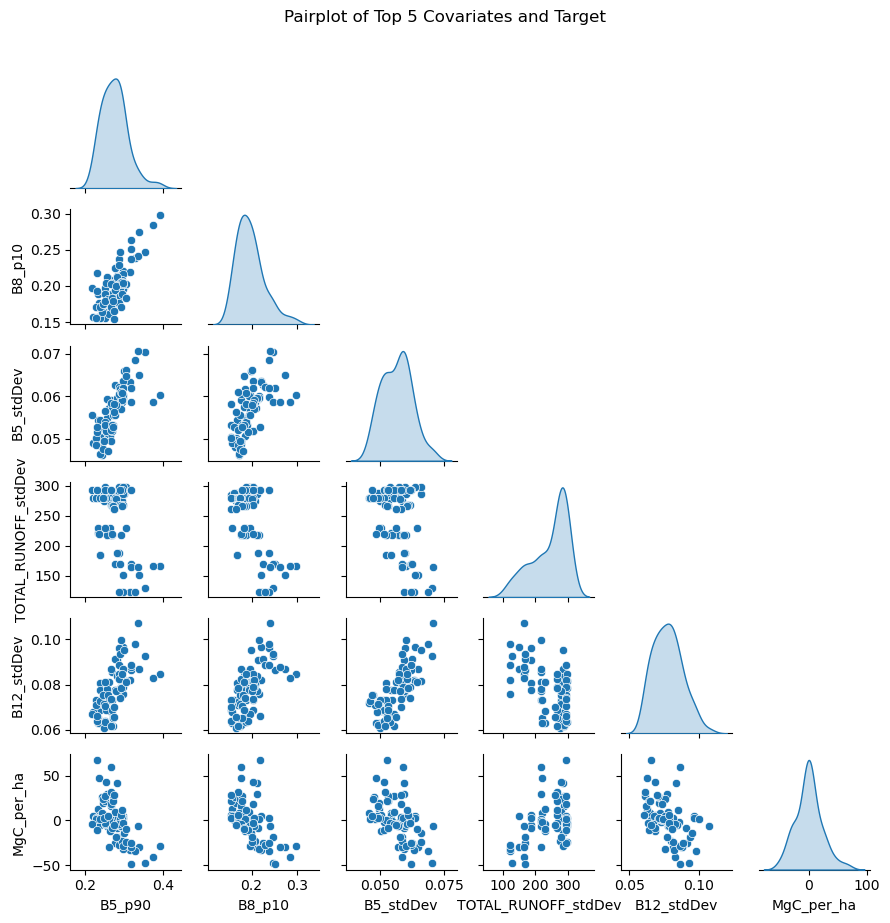

In [343]:
# Include the target in the plot
plot_vars = selected_predictors + ['MgC_per_ha']
sns.pairplot(soc_training_df[plot_vars], diag_kind='kde', corner=True, height=1.5)
plt.suptitle("Pairplot of Top 5 Covariates and Target", y=1.02)
plt.tight_layout()
plt.show()

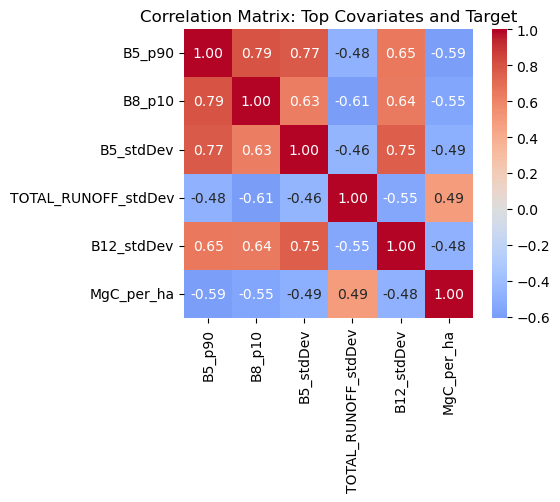

In [344]:
# Compute correlation matrix
corr_matrix = soc_training_df[selected_predictors + ['MgC_per_ha']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", square=True)
plt.title("Correlation Matrix: Top Covariates and Target", fontsize=12)
plt.tight_layout()
plt.show()

#### Train RF Model in Earth Engine

In [345]:
# Train the classifier (Random Forest)
rf = ee.Classifier.smileRandomForest(numberOfTrees=100, maxNodes=30).setOutputMode('REGRESSION')

trained_rf = rf.train(
    features=soc_training_fc,
    classProperty=target_variable,
    inputProperties=selected_predictors
)

predicted_soc = combined_covariates.select(selected_predictors).classify(trained_rf).rename('predicted_SOC')

In [ ]:
vis_soc_prediction = {
    'min': -50,  # Minimum value of predicted SOC (adjust based on your dataset range)
    'max': 50,   # Maximum value of predicted SOC (adjust based on your dataset range)
    'palette': [
        'blue',  # Low values (negative SOC or lower carbon stocks)
        'green', # Mid-range values (average carbon stocks)
        'yellow', # High values (higher carbon stocks)
        'red'     # Highest values (very high carbon stocks)
    ]
}

Map.addLayer(predicted_soc.clip(study_area), vis_soc_prediction, 'SOC_RF_prediction', False)
Map

### Model Validation

In [348]:
# Add a random column to enable splitting
soc_training_fc = soc_training_fc.randomColumn('random')

# Split: 80% for training, 20% for testing
train_split = soc_training_fc.filter(ee.Filter.lt('random', 0.8))
test_split = soc_training_fc.filter(ee.Filter.gte('random', 0.8))

# Re-train the classifier on 80% split
trained_split_rf = rf.train(
    features=train_split,
    classProperty=target_variable,
    inputProperties=selected_predictors
)

# Apply the trained model to the 20% hold-out
test_predicted = test_split.classify(trained_split_rf, 'predicted')

# Compute regression metrics
regression_metrics = test_predicted.errorMatrix(target_variable, 'predicted')

# Apply the model to the test set
test_predicted = test_split.classify(trained_split_rf).map(lambda f: f.set('predicted', f.get('classification')))

# Extract lists of predicted and actual values
observed = test_predicted.aggregate_array(target_variable)
predicted = test_predicted.aggregate_array('predicted')

# Compute metrics using ee.Reducer
joined = ee.Array.cat([observed, predicted], axis=1)

# Mean of observed
mean_obs = ee.Number(observed.reduce(ee.Reducer.mean()))

# Compute Total Sum of Squares (SST)
sst = observed.map(lambda val: ee.Number(val).subtract(mean_obs).pow(2))
sst_sum = ee.List(sst).reduce(ee.Reducer.sum())

# Compute Residual Sum of Squares (SSR)
residuals = observed.zip(predicted).map(
    lambda pair: ee.Number(ee.List(pair).get(0)).subtract(ee.Number(ee.List(pair).get(1))).pow(2)
)
ssr_sum = ee.List(residuals).reduce(ee.Reducer.sum())

# R² = 1 - SSR / SST
r2 = ee.Number(1).subtract(ee.Number(ssr_sum).divide(sst_sum))

# RMSE = sqrt(mean((obs - pred)^2))
rmse = ee.Number(ssr_sum).divide(observed.length()).sqrt()

# Print results
print('R²:', r2.getInfo())
print('RMSE:', rmse.getInfo())

R²: 0.1065008072103617
RMSE: 20.65489076519228


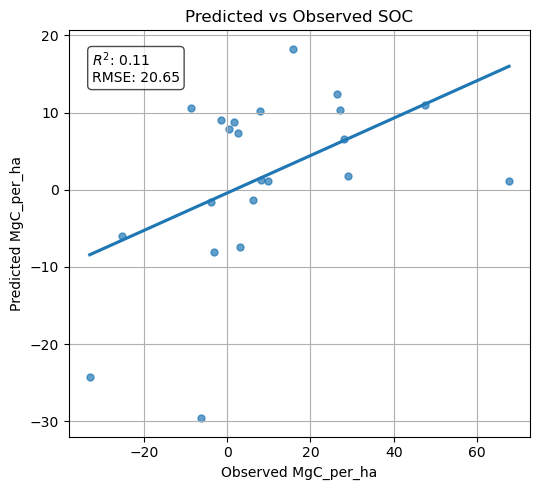

In [352]:
observed_list = observed.getInfo()   # True values (MgC_per_ha)
predicted_list = predicted.getInfo() # Predicted values from classifier

# Convert to variables
y_true = observed_list
y_pred = predicted_list

# Compute R² and RMSE in Python for annotation
r2 = r2_score(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)

# Scatter plot
plt.figure(figsize=(5.5, 5))
sns.regplot(x=y_true, y=y_pred, ci=None, scatter_kws={'s': 25, 'alpha': 0.7})
plt.xlabel("Observed MgC_per_ha")
plt.ylabel("Predicted MgC_per_ha")
plt.title("Predicted vs Observed SOC")

# Annotate with R² and RMSE
plt.text(0.05, 0.95,
         f'$R^2$: {r2:.2f}\nRMSE: {rmse:.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.grid(True)
plt.tight_layout()
plt.show()